# Detect pipeline
This notebook will run through how to use the detect function on a subset of the Tasman Sea domain. 

I'm primarily writing this as the PBS job has done some funny things and i'm hoping this will catch out whatever is tripping that up. 

In [1]:
import xarray as xr
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
import glob
from xmhw.xmhw import threshold
import os

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)#, n_workers=28)
client

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34841 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34841/status,
Dashboard: /proxy/34841/status,Workers: 1
Total threads: 1,Total memory: 4.50 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43089,Workers: 1
Dashboard: /proxy/34841/status,Total threads: 1
Started: Just now,Total memory: 4.50 GiB
Comm: tcp://127.0.0.1:33011,Total threads: 1
Dashboard: /proxy/37493/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:41233,


### Data 

In [4]:
# EAC-003 paths
# eac-zarr
zarr_path = '/home/581/jr5971/scratch/mom6-setonix/subsetted_data/'
easttas_eac003_path = zarr_path + 'etas-tob.nc'

In [5]:
eac003_temp = xr.open_dataarray(easttas_eac003_path)
eac003_temp

<xarray.DataArray 'tob' (time: 10501, yh: 393, xh: 210)>
[866647530 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01
  * time     (time) object 1990-02-02 12:00:00 ... 2016-11-30 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [18]:
eac003_temp


<xarray.DataArray 'tob' (time: 10501, yh: 393, xh: 210)>
[866647530 values with dtype=float32]
Coordinates:
  * xh       (xh) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * yh       (yh) float64 -44.99 -44.97 -44.94 -44.92 ... -35.06 -35.04 -35.01
  * time     (time) object 1990-02-02 12:00:00 ... 2016-11-30 12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [23]:
int(len(eac003_temp.yh)/12)

32

In [21]:
eac003_temp.isel(yh=slice(0, 12)).nbytes/1e6

105.85008

In [9]:
eac003_temp.encoding

{'zlib': False,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': False,
 'complevel': 0,
 'fletcher32': False,
 'contiguous': True,
 'chunksizes': None,
 'source': '/home/581/jr5971/scratch/mom6-setonix/subsetted_data/etas-tob.nc',
 'original_shape': (10501, 393, 210),
 'dtype': dtype('float32'),
 'missing_value': 1e+20,
 '_FillValue': 1e+20}

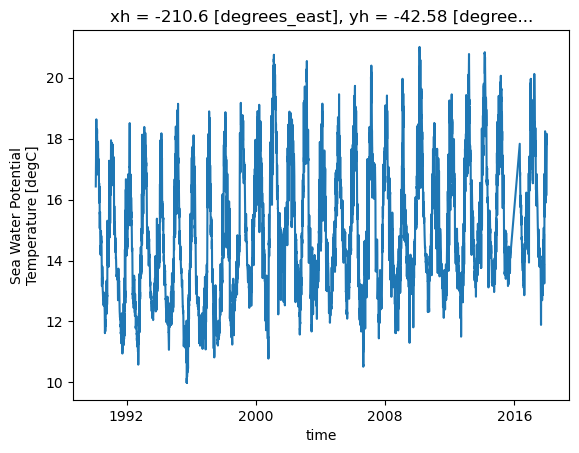

In [5]:
eac003_temp.isel(xh=100, yh=100, z_l=0).plot()

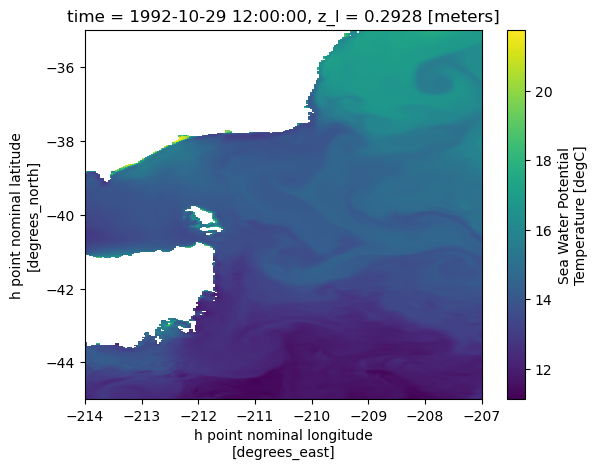

In [6]:
eac003_temp.isel(time=1000, z_l=0).plot()

### Breaking domain up in 3 dimensions
Here, I'm figuring out the best way to split the domain up when we are calculating 3D MHWs. 

Essentially, once we select a single layer, the chunksize is quite small, for instance:

In [5]:
temp = eac003_temp.rename({'xh':'lon', 'yh':'lat'})
tt, zt, yt, xt = temp.chunks
# native chunks
y_chunk_native = yt[0]
x_chunk_native = xt[0]
print(f'time: {tt[0]}, lat: {y_chunk_native}, lon: {x_chunk_native}')
y_factor=1
print(f'chunksize: {temp.isel(z_l=0, lat=slice(0, int(y_chunk_native*y_factor))).nbytes/1e6} MB')

time: 9982, lat: 12, lon: 5
chunksize: 100.61856 MB


So, say we take x_chunk to be -1, the only thing we need to modify is the y_chunk, which I would say we just make a factor of the native chunking. That makes the most sense in terms of loading in different sections of the native data. 

In [6]:
mhw_result_path = '/home/581/jr5971/jr5971/mhw-analysis/eac_attempt3/'

**Change time format**

**Test Threshold**

#### Test on single chunk

In [12]:
# select depth
zl = 0
# select chunk
y_chunk = int(y_chunk_native * 0.5)
temp_chunk = temp.isel(lat=slice(y_chunk*0, y_chunk*1), z_l=zl)
temp_chunk

<xarray.DataArray 'thetao' (time: 9982, lat: 6, lon: 210)>
dask.array<getitem, shape=(9982, 6, 210), dtype=float32, chunksize=(9982, 6, 5), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2017-12-31 12:00:00
  * lon      (lon) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * lat      (lat) float64 -44.99 -44.97 -44.94 -44.92 -44.89 -44.87
    z_l      float64 0.2928
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [13]:
%%time
# test threshold on single cell
temp1d = temp_chunk.isel(lon=-1, lat=-1).compute()
temp1d['time'] = temp1d['time'].astype('datetime64[ns]')
temp1d
clim1d = threshold(temp1d)

calendar not in keys
CPU times: user 723 ms, sys: 147 ms, total: 870 ms
Wall time: 2.11 s


In [14]:
%%time
temp_chunk['time'] = temp_chunk['time'].astype('datetime64[ns]')
temp_chunk.drop_vars('z_l')
temp_chunk = temp_chunk.compute()

CPU times: user 620 ms, sys: 184 ms, total: 805 ms
Wall time: 1.83 s


In [22]:
temp_chunk[:,:,-5:].nbytes/1e6

1.19784

In [23]:
temp_chunk[:,:,-5:].drop_vars('z_l')

<xarray.DataArray 'thetao' (time: 9982, lat: 6, lon: 5)>
array([[[13.088711 , 13.100833 , 13.112153 , 13.124343 , 13.139657 ],
        [13.110375 , 13.126329 , 13.14132  , 13.156143 , 13.17303  ],
        [13.151636 , 13.180034 , 13.206804 , 13.233323 , 13.263038 ],
        [13.193844 , 13.235576 , 13.274704 , 13.312444 , 13.354683 ],
        [13.239941 , 13.297935 , 13.351342 , 13.40057  , 13.452132 ],
        [13.297406 , 13.376395 , 13.447589 , 13.507961 , 13.560411 ]],

       [[13.157182 , 13.1724415, 13.183605 , 13.19773  , 13.2126465],
        [13.196105 , 13.217864 , 13.241877 , 13.261567 , 13.285972 ],
        [13.242238 , 13.283899 , 13.320031 , 13.35263  , 13.386783 ],
        [13.297672 , 13.352107 , 13.404595 , 13.451045 , 13.496963 ],
        [13.357054 , 13.4312315, 13.5005865, 13.558491 , 13.61029  ],
        [13.41332  , 13.500124 , 13.581472 , 13.648547 , 13.707874 ]],

       [[13.128385 , 13.138032 , 13.149492 , 13.163244 , 13.177479 ],
        [13.158542 , 13.170764 , 13.18369  , 13.197636 , 13.212899 ],
        [13.207772 , 13.230262 , 13.252343 , 13.274791 , 13.297841 ],
        [13.273891 , 13.314346 , 13.352621 , 13.388193 , 13.423396 ],
        [13.355874 , 13.414739 , 13.471744 , 13.524144 , 13.570749 ],
        [13.437141 , 13.514764 , 13.585255 , 13.647952 , 13.703202 ]],
...
        [15.840662 , 15.940884 , 16.011353 , 16.107727 , 16.175303 ],
        [15.8850565, 15.967586 , 16.081871 , 16.124294 , 16.21614  ],
        [15.926963 , 16.034632 , 16.092934 , 16.177673 , 16.204231 ],
        [15.988347 , 16.052732 , 16.116787 , 16.172516 , 16.193655 ],
        [15.987611 , 16.076061 , 16.1391   , 16.187773 , 16.186172 ]],

       [[14.684383 , 14.705359 , 14.727344 , 14.750549 , 14.7925   ],
        [14.701849 , 14.719493 , 14.745808 , 14.781932 , 14.83689  ],
        [14.71582  , 14.737538 , 14.771206 , 14.819497 , 14.890448 ],
        [14.732116 , 14.759457 , 14.809734 , 14.875334 , 14.955354 ],
        [14.751273 , 14.794359 , 14.860717 , 14.936164 , 14.988266 ],
        [14.775123 , 14.835088 , 14.911487 , 14.977544 , 15.005713 ]],

       [[14.568626 , 14.590494 , 14.602684 , 14.610013 , 14.622967 ],
        [14.584021 , 14.602329 , 14.613608 , 14.622386 , 14.634283 ],
        [14.599562 , 14.615574 , 14.625616 , 14.6329365, 14.646346 ],
        [14.615233 , 14.628333 , 14.635512 , 14.646423 , 14.677352 ],
        [14.6299515, 14.639155 , 14.6507845, 14.684089 , 14.741202 ],
        [14.641945 , 14.655959 , 14.693805 , 14.7568865, 14.800556 ]]],
      dtype=float32)
Coordinates:
  * lon      (lon) float64 -207.1 -207.1 -207.1 -207.0 -207.0
  * lat      (lat) float64 -44.99 -44.97 -44.94 -44.92 -44.89 -44.87
  * time     (time) datetime64[ns] 1990-02-02T12:00:00 ... 2017-12-31T12:00:00
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [24]:
%%time
# calculate threshold
clim = threshold(temp_chunk[:,:,-5:].drop_vars('z_l'))
clim

calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 49.60 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4.25 s, sys: 589 ms, total: 4.84 s
Wall time: 7.13 s


<xarray.Dataset>
Dimensions:   (lon: 5, lat: 6, doy: 366)
Coordinates:
  * lon       (lon) float64 -207.1 -207.1 -207.1 -207.0 -207.0
  * lat       (lat) float64 -44.99 -44.97 -44.94 -44.92 -44.89 -44.87
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
    quantile  float64 0.9
Data variables:
    thresh    (doy, lon, lat) float64 dask.array<chunksize=(365, 1, 6), meta=np.ndarray>
    seas      (doy, lon, lat) float32 dask.array<chunksize=(365, 1, 6), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2024-04-23: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

Now, let's select a subset that uses a small 2D surface, plus say 5 depth levels and test this out. 

In [8]:
# select a 5x5x5 cube and see how big it is
x_block = 5
y_block = 5
z_block = 5
temp = temp[:, :z_block, 100:100+y_block, 100:100+x_block]
temp['time'] = temp_block['time'].astype('datetime64[ns]')
temp_block.data

dask.array<getitem, shape=(9982, 5, 5, 5), dtype=float32, chunksize=(9982, 5, 5, 5), chunktype=numpy.ndarray>

Note the subset selected all exists in a single chunk which is nice to see. 

In [25]:
%%time
# test different ways to loop through the 3D block;
# ONE LAYER AT A TIME;
clim_ls = []
for layer in range(2):
    # select the layer and drop depth coord;
    temp2d = temp_block.isel(z_l=layer).drop_vars('z_l').compute()
    print(f"calculating threshold on depth level {temp_block['z_l'][layer].values} m")
    clim2d = threshold(temp2d)
    
    # assign depth coordinate/dimension
    clim2d['z_l'] = temp_block['z_l'][layer]
    clim2d = clim2d.assign_coords(z_l = clim2d['z_l'])
    clim2d = clim2d.expand_dims('z_l')
    # store the results
    print(f'Appending results')
    clim_ls.append(clim2d)
# combine results
clim3d = xr.combine_by_coords(clim_ls)

calculating threshold on depth level 0.29280103724500783 m
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 41.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Appending results
calculating threshold on depth level 0.899903328117488 m
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 41.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Appending results
CPU times: user 7.71 s, sys: 10.1 s, total: 17.8 s
Wall time: 24 s


Alrighty - well there it is; the 3D MHW code. We could add some dask.delayed work in there but for now, let's just get this going with what we have. 

Finally, let's try multiple horizontal blocks for each layer;


In [37]:
y_block

24

In [14]:
# select a 5x5x5 cube and see how big it is
x_block = -1
y_chunksize = 4 # choosing a small number irrespective of chunks
z_block = 1
y_chunks = 1
temp_block = temp[:, :z_block, 100:100+(y_chunksize*y_chunks)]
temp_block['time'] = temp_block['time'].astype('datetime64[ns]')
temp_block.data

dask.array<getitem, shape=(9982, 1, 4, 210), dtype=float32, chunksize=(9982, 1, 4, 5), chunktype=numpy.ndarray>

In [17]:
y_chunks = len(temp['lat'])//2


In [31]:
y_chunks

32

### Investigating lag
Try: 
- Only calculating climatologies, then when that's finished, using that for the detect function

In [7]:
from xmhw.xmhw import detect
from datetime import datetime as ddt

In [8]:
def assign_depth_dim(array, z_coord):
    array['z_l'] = z_coord
    array = array.assign_coords(z_l=array['z_l'])
    array = array.expand_dims('z_l')
    return array

In [9]:
temp.data

dask.array<open_dataset-thetao, shape=(9982, 50, 393, 210), dtype=float32, chunksize=(9982, 50, 12, 5), chunktype=numpy.ndarray>

In [10]:
workdir = mhw_result_path

In [11]:
depths = np.linspace(0,100, 5)
depths

array([  0.,  25.,  50.,  75., 100.])

In [ ]:
%%time
# ONE LAYER AT A TIME;
# WHOLE DATASET
y_chunksize = 12
y_chunks = len(temp['lat'])//y_chunksize
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 5

os.makedirs(workdir+'/temp-res', exist_ok=True)


temp['time'] = temp['time'].astype('datetime64[ns]')
for z_idx, depth in enumerate(depths[:]):
    # select the layer;
    print(f'Depth level: {depth} m')
    temp2d = temp.sel(z_l=depth, method='nearest')
    # select horizontal blocks
    # clim2d_ls = []
    start_layer = ddt.now()
    for j in range(0,y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {z_idx} ({depth}m) of {len(depths[1:])} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        print(f'saving clim...')
        start_save = ddt.now()
        clim_2dblock.to_netcdf(workdir+f'/temp-res/clim2d_tmp_z{int(depth)}m_{j:03d}.nc')
        print(f'time to save: {(ddt.now()-start_save).total_seconds()}')
        # store results
        # clim2d_ls.append(clim_2dblock)
        # if j != 0 and j % 5 == 0:
        #     print(f'saving updated clim2d_ls; j= {j}')
        #     clim2d_tmp = xr.combine_by_coords(clim2d_ls)
        #     clim2d_tmp.to_netcdf(workdir+'/temp-res/clim2d_tmp_z{layer}_{j:03d}.nc')
        del clim_2dblock, ts
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp['z_l'][layer])
    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)

# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

Depth level: 0.0 m
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (0.0m) of 4 | y: 0 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
%%time
# ONE LAYER AT A TIME;
# WHOLE DATASET ZARR SAVING EVERY 5 ITERATIONS
y_chunksize = 12
y_chunks = len(temp['lat'])//y_chunksize
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 5

os.makedirs(workdir+'/temp-res', exist_ok=True)

temp['time'] = temp['time'].astype('datetime64[ns]')
for z_idx, depth in enumerate(depths[1:]):
    # select the layer;
    print(f'Depth level: {depth} m')
    temp2d = temp.sel(z_l=depth, method='nearest')
    # select horizontal blocks
    clim2d_ls = []
    start_layer = ddt.now()
    for j in range(0,y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {z_idx} ({depth}m) of {len(depths[1:])} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # print(f'saving clim...')
        # start_save = ddt.now()
        # clim_2dblock.to_netcdf(workdir+f'/temp-res/clim2d_tmp_z{int(depth)}m_{j:03d}.nc')
        # print(f'time to save: {(ddt.now()-start_save).total_seconds()}')
        # store results
        clim2d_ls.append(clim_2dblock)
        if j != 0 and j % 5 == 0:
            start_save = ddt.now()
            print(f'saving updated clim2d_ls; j= {j}')
            clim2d_tmp = xr.combine_by_coords(clim2d_ls[j-5:j])
            clim2d_tmp.to_zarr(workdir+f'/temp-res/clim2d_tmp_z{int(depth)}m_{j:03d}.zarr', consolidated=True)
            print(f'time to save: {(ddt.now()-start_save).total_seconds()}')
        del clim_2dblock, ts
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp['z_l'][layer])
    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)

# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

Depth level: 25.0 m
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 0 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 409.835896
saving clim...
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 1 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 441.021532
saving clim...
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 2 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 443.08407
saving clim...
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 3 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.06 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 439.71425
saving clim...
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 4 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 4.03 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-04-24 09:31:09,356 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.53 GiB -- Worker memory limit: 4.00 GiB


theshold time: 446.75542
saving clim...
array size: (9982, 12, 210) | 100.61856 MB
threshold calc on z: 0 (25.0m) of 4 | y: 5 of 32
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 3.40 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 370.03147
saving clim...
saving updated clim2d_ls; j= 5


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 254.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-04-24 09:48:02,639 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 09:49:03,143 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-24 09:49:48,765 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 09:53:48,032 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-24 10:00:46,096 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [24]:
%%time
clim_2dblock = clim_2dblock.compute()
clim_2dblock

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 50.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4min 54s, sys: 17.1 s, total: 5min 11s
Wall time: 5min 11s


<xarray.Dataset>
Dimensions:   (lon: 210, lat: 12, doy: 366)
Coordinates:
  * lon       (lon) float64 -214.0 -213.9 -213.9 -213.9 ... -207.1 -207.0 -207.0
  * lat       (lat) float64 -44.99 -44.97 -44.94 -44.92 ... -44.78 -44.75 -44.73
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
    quantile  float64 0.9
Data variables:
    thresh    (doy, lon, lat) float64 14.3 14.31 14.32 ... 13.86 13.86 13.86
    seas      (doy, lon, lat) float32 12.79 12.82 12.85 ... 12.49 12.5 12.5
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2024-04-24: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

In [25]:
print(depth, j)

50.0 0


In [27]:
%%time
clim_2dblock.to_netcdf(workdir + f'/temp-res/clim2d_tmp_z{int(depth)}m_{j:03d}.nc')

CPU times: user 64.8 ms, sys: 31.6 ms, total: 96.4 ms
Wall time: 115 ms


**Observations**
Job: 28 cores, array size 100MB:
* Long pause after 'calendar not in keys' with a quiet dashboard.
* Now, things are happening - the total tasks is building, memory is low, tasks at 37K, 50K, 100K, 140K, memory up around 1GB, 180K, 210K memory pushing 1.5GB per worker - **peaked at 210K**. Now the 'waiting' and 'tota' is going down rapdily. Total on 110K. The task stream isn't necessarily very full. And that's it - **485 s or 8 minutes** to process 100 MB. Multiply that by 32: 4.3 hours to process the whole lot. It'll be interesting to see how that holds up. Also how the worker memory holds up - is it able to clear out everything, or does memory accumulate over each iteration - hopefully not.ss

**Detect Loop**

Here, it's probably easier if we load the entire clim dataset in at once (at least per level) as it's not overly large anyway and allows some flexibility with the detect function. 



In [ ]:
# test detect out to understand it's capacity. 
# size of array:
y_chunksize = 12
temp_block = temp.isel(lat=slice(-y_chunksize,None), z_l=0)
print(f'{temp_block.nbytes/1e6} MB')
# load in clim data

start = ddt.now()
mhw, intermediate = detect(

In [ ]:
%%time
# ONE LAYER AT A TIME;
# WHOLE DATASET
y_chunksize = 2
y_chunks = len(temp['lat'])//y_chunksize
mhw_ls = []
int_ls = []
n_layers = 4

temp['time'] = temp['time'].astype('datetime64[ns]')
for layer in range(n_layers):
    # select the layer;
    temp2d = temp.isel(z_l=layer)
    # select horizontal blocks
    clim2d_ls = []
    mhw2d_ls = []
    int2d_ls = []
    start_layer = ddt.now()
    for j in range(y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {layer} of {n_layers} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # # detect function on 2d block
        # th = clim_2dblock['thresh']
        # se = clim_2dblock['seas']
        # print('... and detecting events ...')
        # start_detect = ddt.now()
        # mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
        # print(f"detect time: {(ddt.now() - start_detect).total_seconds()}")
        # store results
        clim2d_ls.append(clim_2dblock)
        # mhw2d_ls.append(mhw)
        # int2d_ls.append(intermediate)
        del clim_2dblock, ts
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    # mhw2d = xr.combine_nested(mhw2d_ls, concat_dim='lat')
    # int2d = xr.combine_by_coords(int2d_ls)
    
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp['z_l'][layer])
    # mhw2d = assign_depth_dim(mhw2d, temp['z_l'][layer])
    # int2d = assign_depth_dim(int2d, temp['z_l'][layer])

    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)
    # mhw_ls.append(mhw2d)
    # int_ls.append(int2d)
# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 0 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 88.140084
array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 1 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 86.708763
array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 2 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
%%time
# ONE LAYER AT A TIME;
# WHOLE DATASET
y_chunksize = 2
y_chunks = len(temp['lat'])//y_chunksize
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 4

temp['time'] = temp['time'].astype('datetime64[ns]')
for layer in range(n_layers):
    # select the layer;
    temp2d = temp.isel(z_l=layer)
    # select horizontal blocks
    clim2d_ls = []
    mhw2d_ls = []
    int2d_ls = []
    start_layer = ddt.now()
    for j in range(y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {layer} of {n_layers} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # # detect function on 2d block
        # th = clim_2dblock['thresh']
        # se = clim_2dblock['seas']
        # print('... and detecting events ...')
        # start_detect = ddt.now()
        # mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
        # print(f"detect time: {(ddt.now() - start_detect).total_seconds()}")
        # store results
        clim2d_ls.append(clim_2dblock)
        # mhw2d_ls.append(mhw)
        # int2d_ls.append(intermediate)
        del clim_2dblock, ts
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    # mhw2d = xr.combine_nested(mhw2d_ls, concat_dim='lat')
    # int2d = xr.combine_by_coords(int2d_ls)
    
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp['z_l'][layer])
    # mhw2d = assign_depth_dim(mhw2d, temp['z_l'][layer])
    # int2d = assign_depth_dim(int2d, temp['z_l'][layer])

    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)
    # mhw_ls.append(mhw2d)
    # int_ls.append(int2d)
# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 0 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 88.140084
array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 1 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 86.708763
array size: (9982, 2, 210) | 16.76976 MB
threshold calc on z: 0 of 4 | y: 2 of 196
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 693.35 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [19]:
%%time
# ONE LAYER AT A TIME;
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 2
for layer in range(n_layers):
    # select the layer;
    temp2d = temp_block.isel(z_l=layer)
    # select horizontal blocks
    clim2d_ls = []
    mhw2d_ls = []
    int2d_ls = []
    start_layer = ddt.now()
    for j in range(y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {layer} of {n_layers} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # detect function on 2d block
        th = clim_2dblock['thresh']
        se = clim_2dblock['seas']
        print('... and detecting events ...')
        start_detect = ddt.now()
        mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
        print(f"detect time: {(ddt.now() - start_detect).total_seconds()}")
        # store results
        clim2d_ls.append(clim_2dblock)
        mhw2d_ls.append(mhw)
        int2d_ls.append(intermediate)
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    mhw2d = xr.combine_nested(mhw2d_ls, concat_dim='lat')
    int2d = xr.combine_by_coords(int2d_ls)
    
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp_block['z_l'][layer])
    mhw2d = assign_depth_dim(mhw2d, temp_block['z_l'][layer])
    int2d = assign_depth_dim(int2d, temp_block['z_l'][layer])

    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)
    mhw_ls.append(mhw2d)
    int_ls.append(int2d)
# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 0 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.28509
... and detecting events ...
detect time: 10.192079
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 1 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.457012
... and detecting events ...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]


detect time: 9.938406
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 2 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.62414
... and detecting events ...
detect time: 10.272326
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 3 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.684141
... and detecting events ...
detect time: 10.830503
Layer 3 took 76.871944
combining 2d results for layer 0
Appending 2d results to 3d list
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 0 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 9.18683
... and detecting events ...
detect time: 10.202245
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 1 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.346655
... and detecting events ...
detect time: 9.835634
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 2 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.895271
... and detecting events ...
detect time: 9.648631
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 3 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 9.102405
... and detecting events ...
detect time: 10.352526
Layer 3 took 77.507934
combining 2d results for layer 1
Appending 2d results to 3d list
CPU times: user 1min 53s, sys: 4.94 s, total: 1min 58s
Wall time: 2min 34s


In [19]:
%%time
# ONE LAYER AT A TIME;
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 2
for layer in range(n_layers):
    # select the layer;
    temp2d = temp_block.isel(z_l=layer)
    # select horizontal blocks
    clim2d_ls = []
    mhw2d_ls = []
    int2d_ls = []
    start_layer = ddt.now()
    for j in range(y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {layer} of {n_layers} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # detect function on 2d block
        th = clim_2dblock['thresh']
        se = clim_2dblock['seas']
        print('... and detecting events ...')
        start_detect = ddt.now()
        mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
        print(f"detect time: {(ddt.now() - start_detect).total_seconds()}")
        # store results
        clim2d_ls.append(clim_2dblock)
        mhw2d_ls.append(mhw)
        int2d_ls.append(intermediate)
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    mhw2d = xr.combine_nested(mhw2d_ls, concat_dim='lat')
    int2d = xr.combine_by_coords(int2d_ls)
    
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp_block['z_l'][layer])
    mhw2d = assign_depth_dim(mhw2d, temp_block['z_l'][layer])
    int2d = assign_depth_dim(int2d, temp_block['z_l'][layer])

    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)
    mhw_ls.append(mhw2d)
    int_ls.append(int2d)
# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 0 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.28509
... and detecting events ...
detect time: 10.192079
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 1 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.457012
... and detecting events ...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]


detect time: 9.938406
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 2 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.62414
... and detecting events ...
detect time: 10.272326
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 0 of 2 | y: 3 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.684141
... and detecting events ...
detect time: 10.830503
Layer 3 took 76.871944
combining 2d results for layer 0
Appending 2d results to 3d list
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 0 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 9.18683
... and detecting events ...
detect time: 10.202245
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 1 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.346655
... and detecting events ...
detect time: 9.835634
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 2 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.895271
... and detecting events ...
detect time: 9.648631
array size: (9982, 4, 10) | 1.59712 MB
threshold calc on z: 1 of 2 | y: 3 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 66.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 9.102405
... and detecting events ...
detect time: 10.352526
Layer 3 took 77.507934
combining 2d results for layer 1
Appending 2d results to 3d list
CPU times: user 1min 53s, sys: 4.94 s, total: 1min 58s
Wall time: 2min 34s


In [15]:
%%time
# ONE LAYER AT A TIME;
clim_ls = []
mhw_ls = []
int_ls = []
n_layers = 2
for layer in range(n_layers):
    # select the layer;
    temp2d = temp_block.isel(z_l=layer)
    # select horizontal blocks
    clim2d_ls = []
    mhw2d_ls = []
    int2d_ls = []
    start_layer = ddt.now()
    for j in range(y_chunks):
        lat0 = j*y_chunksize
        lat1 = (j+1)*y_chunksize
        # select block
        ts = temp2d.isel(lat=slice(int(lat0), int(lat1))).compute()
        ts = ts.drop_vars('z_l')
        print(f"array size: {ts.shape} | {ts.nbytes/1e6} MB")
        print(f"threshold calc on z: {layer} of {n_layers} | y: {j} of {y_chunks}")
        start_thresh = ddt.now()
        clim_2dblock = threshold(ts)
        print(f"theshold time: {(ddt.now()-start_thresh).total_seconds()}")
        # detect function on 2d block
        th = clim_2dblock['thresh']
        se = clim_2dblock['seas']
        print('... and detecting events ...')
        start_detect = ddt.now()
        mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
        print(f"detect time: {(ddt.now() - start_detect).total_seconds()}")
        # store results
        clim2d_ls.append(clim_2dblock)
        mhw2d_ls.append(mhw)
        int2d_ls.append(intermediate)
        
    # make clim2d a dataset
    print(f'Layer {j} took {(ddt.now()-start_layer).total_seconds()}')
    print(f'combining 2d results for layer {layer}')
    clim2d = xr.combine_by_coords(clim2d_ls)
    mhw2d = xr.combine_nested(mhw2d_ls, concat_dim='lat')
    int2d = xr.combine_by_coords(int2d_ls)
    
    # assign depth coordinate/dimension
    clim2d = assign_depth_dim(clim2d, temp_block['z_l'][layer])
    mhw2d = assign_depth_dim(mhw2d, temp_block['z_l'][layer])
    int2d = assign_depth_dim(int2d, temp_block['z_l'][layer])

    # store the results
    print(f'Appending 2d results to 3d list')
    clim_ls.append(clim2d)
    mhw_ls.append(mhw2d)
    int_ls.append(int2d)
# # combine results
# clim3d = xr.combine_by_coords(clim_ls)

array size: (9982, 4, 5) | 0.79856 MB
threshold calc on z: 0 of 2 | y: 0 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 8.927028
... and detecting events ...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be se

detect time: 4.516645
array size: (9982, 4, 5) | 0.79856 MB
threshold calc on z: 0 of 2 | y: 1 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 4.197231
... and detecting events ...
detect time: 4.684504
array size: (9982, 4, 5) | 0.79856 MB
threshold calc on z: 0 of 2 | y: 2 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 4.201272
... and detecting events ...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]


detect time: 4.45391
array size: (9982, 4, 5) | 0.79856 MB
threshold calc on z: 0 of 2 | y: 3 of 4
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 33.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


theshold time: 4.463598
... and detecting events ...


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]


detect time: 4.772267
Layer 3 took 45.860752
combining 2d results for layer 0


NameError: name 'assign_depth_dim' is not defined

In [69]:
clim3d = xr.combine_by_coords(clim_ls)
mhw3d = xr.combine_by_coords(mhw_ls)
int3d = xr.combine_by_coords(int_ls)

In [72]:
# simplified block selection
tt, zt, yt, xt = temp.chunks
y_chunk_native = yt[0]
y_factor = 1
y_chunksize = int(y_chunk_native * y_factor)

And there we go - the 3d MHW results combined into single datasets. 

The next thing to consider is how this will scale across the entire horizontal area. And then, if that is successful, then how to store the results - do we attempt to do so as we've done above? Or should we try saving them individually? or for individual layers? 

* let's first try as above. How many lat cells am I going to go with?

In [71]:
temp[:, 0, :12, :].data

dask.array<getitem, shape=(9982, 12, 210), dtype=float32, chunksize=(9982, 12, 5), chunktype=numpy.ndarray>

Okay, let's go with this for a first attempt - and try to throw say 48 cores at it. 

In [ ]:
%%time
# results_th = []
# results_det = []
# results_int = []

results_th_alldepth = {}

# for k in range(len(temp.z_l)):
for k in np.arange(0, 50, 5):
    start_depth_timer = timer()
    ts_depth = temp.isel(z_l = k)
    ts_depth = ts_depth.drop_vars('z_l')
    results_th = []
    for j in range(ytblocks):
        start_loop = timer()
        yt_from = j * ytstep
        yt_to = (j+1) * ytstep
        print(yt_from, yt_to)
        ts = ts_depth.isel(lat=slice(yt_from, yt_to)).load()
        ds_th = threshold(ts)
        results_th.append(ds_th)
        print(f'time for a single chunk: {str(timedelta(seconds=timer()-start_loop))}')

    results_th_alldepth[f'{k}'] = results_th
    print(f'time for a single depth level: {str(timedelta(seconds=timer()-start_depth_timer))}')
    print(f'finished {k}, starting level {k+1}')
    

0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.333806
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.393488
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.665733
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.573079
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.287289
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:00.333885
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 239.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.686095
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 217.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.997010
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 219.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.890454
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 204.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:49.789220
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 179.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:35:14,480 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:42.805343
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 176.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:35:51,444 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:42.221682
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:36:30,309 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:41.672182
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:37:08,787 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:40.331235
70 75
calendar not in keys


2024-03-08 11:37:41,518 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:38:19,339 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:46.059699
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 161.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:38:59,241 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:40.336020
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:39:36,920 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:37.040595
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.008862
90 95
calendar not in keys


2024-03-08 11:40:19,695 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.808045
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:41:02,984 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:36.353249
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:41:42,901 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:38.094679
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 149.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:42:26,623 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:38.745595
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:43:17,678 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:37.667094
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.502969
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 170.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:44:08,405 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:43.047376
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 225.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:44:56,367 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.170950
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 254.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:45:48,905 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.096693
135 140
calendar not in keys


2024-03-08 11:46:39,930 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:47:33,794 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:07.087678
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 250.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:48:30,282 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.164043
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 238.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:49:24,183 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:58.700730
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 248.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:50:23,260 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:58.591074
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 237.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:51:28,059 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:57.761396
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 93.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:21.678844
time for a single depth level: 0:26:10.911591
finished 0, starting level 1
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:52:26,002 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.846444
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:53:29,279 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.929963
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:54:38,112 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:04.444013
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:55:58,276 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.924584
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:57:05,013 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:03.023293
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 248.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.351871
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 237.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:58:24,455 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.474399
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 216.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:59:32,019 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:57.363823
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 211.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.333932
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 196.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:01:01,357 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.610036
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 177.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:02:24,697 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:48.581225
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.782071
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:03:53,123 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:49.446063
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.604195
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:05:19,240 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:47.281860
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 157.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.967172
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.536712
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:06:51,474 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.694278
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.526547
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:08:29,106 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.038806
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.150294
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 149.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.204182
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:10:03,287 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.694035
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.290304
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.339173
125 130
calendar not in keys


2024-03-08 12:11:49,999 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 217.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:58.846775
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 252.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:13:24,333 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:05.563935
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.016958
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 247.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:15:08,118 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:06.110152
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 231.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.462144
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 241.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:16:58,978 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:04.979438
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 229.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.665097
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 90.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:18:57,538 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:34.966118
time for a single depth level: 0:27:07.067090
finished 5, starting level 6
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.049570
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:20:46,239 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:08.217945
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.745077
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:22:41,207 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.361040
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:53.028071
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 244.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:24:43,321 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.442268
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 229.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.416239
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 213.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:26:59,536 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.051832
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 195.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:42.689388
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 181.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:40.571078
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:29:16,407 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.961602
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.785057
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.830581
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 170.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.303592
70 75
calendar not in keys


2024-03-08 12:31:31,647 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 163.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:52.539912
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 154.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.883035
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.113946
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:33:47,294 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:50.196331
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.121702
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.121147
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.414388
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:36:22,759 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:49.944981
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.621275
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.776934
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 163.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.962114
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 212.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:38:57,064 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:05.704246
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 250.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.003554
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.498872
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 240.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:41:36,195 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.603024
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 219.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.727192
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 226.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:44:12,112 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:07.490235
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 218.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.622720
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 86.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:19.878464
time for a single depth level: 0:26:22.689695
finished 10, starting level 11
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.828002
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:46:56,358 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.398175
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.635507
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:49:42,922 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.426562
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.677299
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 240.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:52.173461
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 216.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:52:38,567 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.131787
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 203.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:45.711394
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 182.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.197928
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 178.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.136707
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:55:46,417 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.319885
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.068460
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.093890
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 168.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.121462
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 155.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.702204
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 151.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.509261
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.765119
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.696197
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.350683
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.337033
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.879000
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.939522
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.070693
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.772794
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 154.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.902749
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 205.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:05:33,620 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:10.053093
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 245.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.474783
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.363056
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 230.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.571553
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 210.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:09:02,838 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:11.818193
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.944957
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 209.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:48.791666
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 82.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:20.533511
time for a single depth level: 0:26:10.421190
finished 15, starting level 16
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:22.666337
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.038812
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.137374
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.522317
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 242.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:16:22,397 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:16.876453
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 233.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.164869
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 212.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.414276
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 188.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:42.627971
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:20:03,852 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:08.952003
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 175.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.413385
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.163280
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 164.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.397800
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.895439
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:24:02,409 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:06.928355
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.429735
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.633296
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.978480
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.524125
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.828059
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.758589
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:28:18,601 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.919301
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.961161
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.349356
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.227990
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.876693
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 193.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.162340
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 234.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:32:21,615 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:20.466466
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.126325
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 223.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.696341
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 204.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.099116
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 207.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.544895
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 198.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:36:42,371 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.860782
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 79.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:19.640829
time for a single depth level: 0:26:08.297037
finished 20, starting level 21
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.704188
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.066014
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.528102
15 20
calendar not in keys


2024-03-08 13:41:04,763 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 255.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:29.722889
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 238.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:53.892204
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 225.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:49.957698
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 207.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.562033
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 177.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:45:42,165 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:13.252560
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.442610
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.100418
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.832998
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 159.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.968329
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.667291
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 160.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.494043
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:50:26,000 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:10.509726
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 139.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.579246
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.444900
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.513592
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.759739
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.251342
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.701837
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.553703
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:11.262149
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.359911
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 139.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.841525
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.314691
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 183.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.490876
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 191.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:43.631237
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 179.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.702534
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 185.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [5]:
temp = east_tas_eac003.rename({'xh':'lon', 'yh':'lat'})
# x chunks to be all lon so
x_chunks = -1
# y chunks to be 2 - 5 grid span so
y_chunks = 5
# z chunks to be single depths so
z_l_chunks = 1
temp = temp.chunk({'time':-1, 'lon':x_chunks, 'lat':y_chunks, 'z_l':z_l_chunks})
temp

<xarray.DataArray 'thetao' (time: 3440, z_l: 100, lat: 162, lon: 90)>
dask.array<rechunk-merge, shape=(3440, 100, 162, 90), dtype=float32, chunksize=(3440, 1, 5, 90), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2008-01-01 12:00:00 ... 2017-12-31 12:00:00
  * lon      (lon) float64 -213.0 -212.9 -212.9 -212.9 ... -210.1 -210.0 -210.0
  * lat      (lat) float64 -43.99 -43.97 -43.94 -43.92 ... -40.05 -40.03 -40.0
  * z_l      (z_l) float64 0.2928 0.8999 1.552 ... 4.946e+03 5.134e+03 5.324e+03
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [6]:
_, zt, yt, xt = temp.chunks
ztstep = zt[0]
xtstep = xt[0]
ytstep = yt[0]
ztblocks = len(zt)
xtblocks = len(xt)
ytblocks = len(yt)

In [7]:
print(ztstep, xtstep, ytstep, ztblocks, xtblocks, ytblocks)

1 90 5 100 1 33


In [8]:
from xmhw.xmhw import detect

In [9]:
mhw_result_path = '/home/581/jr5971/jr5971/mhw-analysis/eac-003_easttas/'

In [10]:
temp['time'] = temp['time'].astype('datetime64[ns]')
temp['time']

<xarray.DataArray 'time' (time: 3440)>
array(['2008-01-01T12:00:00.000000000', '2008-01-02T12:00:00.000000000',
       '2008-01-03T12:00:00.000000000', ..., '2017-12-29T12:00:00.000000000',
       '2017-12-30T12:00:00.000000000', '2017-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2017-12-31T12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  JULIAN
    long_name:      time

**Test Threshold**

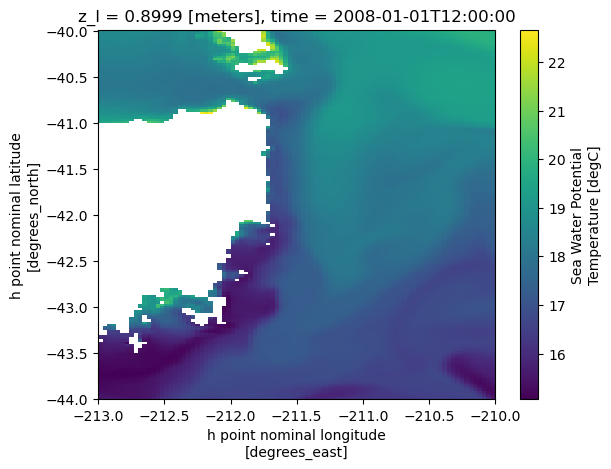

In [11]:
temp.isel(z_l=1, time=0).plot()

In [23]:
temp.isel(z_l=0).drop_vars('z_l')

<xarray.DataArray 'thetao' (time: 3440, lat: 162, lon: 90)>
dask.array<getitem, shape=(3440, 162, 90), dtype=float32, chunksize=(3440, 10, 90), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -213.0 -212.9 -212.9 -212.9 ... -210.1 -210.0 -210.0
  * lat      (lat) float64 -43.99 -43.97 -43.94 -43.92 ... -40.05 -40.03 -40.0
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2017-12-31T12:00:00
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [26]:
timer()

3092419.733269462

In [28]:
np.arange(0, 50, 5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

In [ ]:
%%time
# results_th = []
# results_det = []
# results_int = []

results_th_alldepth = {}

# for k in range(len(temp.z_l)):
for k in np.arange(0, 50, 5):
    start_depth_timer = timer()
    ts_depth = temp.isel(z_l = k)
    ts_depth = ts_depth.drop_vars('z_l')
    results_th = []
    for j in range(ytblocks):
        start_loop = timer()
        yt_from = j * ytstep
        yt_to = (j+1) * ytstep
        print(yt_from, yt_to)
        ts = ts_depth.isel(lat=slice(yt_from, yt_to)).load()
        ds_th = threshold(ts)
        results_th.append(ds_th)
        print(f'time for a single chunk: {str(timedelta(seconds=timer()-start_loop))}')

    results_th_alldepth[f'{k}'] = results_th
    print(f'time for a single depth level: {str(timedelta(seconds=timer()-start_depth_timer))}')
    print(f'finished {k}, starting level {k+1}')
    

0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.333806
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.393488
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.665733
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.573079
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.287289
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:00.333885
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 239.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.686095
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 217.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.997010
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 219.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.890454
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 204.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:49.789220
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 179.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:35:14,480 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:42.805343
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 176.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:35:51,444 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:42.221682
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:36:30,309 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:41.672182
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:37:08,787 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:40.331235
70 75
calendar not in keys


2024-03-08 11:37:41,518 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:38:19,339 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:46.059699
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 161.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:38:59,241 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:40.336020
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:39:36,920 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:37.040595
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.008862
90 95
calendar not in keys


2024-03-08 11:40:19,695 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.808045
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:41:02,984 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:36.353249
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:41:42,901 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:38.094679
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 149.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:42:26,623 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:38.745595
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:43:17,678 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:37.667094
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.502969
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 170.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:44:08,405 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:43.047376
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 225.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:44:56,367 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.170950
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 254.81 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:45:48,905 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.096693
135 140
calendar not in keys


2024-03-08 11:46:39,930 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:47:33,794 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:07.087678
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 250.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:48:30,282 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.164043
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 238.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:49:24,183 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:58.700730
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 248.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:50:23,260 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:58.591074
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 237.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:51:28,059 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:57.761396
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 93.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:21.678844
time for a single depth level: 0:26:10.911591
finished 0, starting level 1
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:52:26,002 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.846444
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:53:29,279 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.929963
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:54:38,112 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:04.444013
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:55:58,276 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.924584
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:57:05,013 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:03.023293
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 248.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.351871
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 237.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:58:24,455 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.474399
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 216.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 11:59:32,019 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:57.363823
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 211.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.333932
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 196.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:01:01,357 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.610036
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 177.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:02:24,697 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:48.581225
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.782071
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:03:53,123 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:49.446063
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.604195
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:05:19,240 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:47.281860
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 157.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.967172
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.536712
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:06:51,474 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.694278
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.526547
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:08:29,106 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.038806
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.150294
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 149.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.204182
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:10:03,287 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:44.694035
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.290304
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.339173
125 130
calendar not in keys


2024-03-08 12:11:49,999 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 217.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:58.846775
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 252.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:13:24,333 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:05.563935
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.016958
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 247.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:15:08,118 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:06.110152
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 231.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.462144
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 241.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:16:58,978 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:04.979438
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 229.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.665097
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 90.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:18:57,538 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:34.966118
time for a single depth level: 0:27:07.067090
finished 5, starting level 6
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.049570
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:20:46,239 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:08.217945
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.745077
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:22:41,207 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.361040
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:53.028071
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 244.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:24:43,321 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.442268
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 229.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.416239
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 213.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:26:59,536 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:01.051832
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 195.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:42.689388
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 181.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:40.571078
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:29:16,407 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:53.961602
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.785057
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.830581
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 170.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.303592
70 75
calendar not in keys


2024-03-08 12:31:31,647 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 163.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:52.539912
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 154.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.883035
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.113946
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:33:47,294 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:50.196331
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.121702
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.121147
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 148.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.414388
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:36:22,759 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:49.944981
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.621275
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 147.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.776934
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 163.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.962114
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 212.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:38:57,064 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:05.704246
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 250.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.003554
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.498872
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 240.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:41:36,195 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.603024
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 219.40 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.727192
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 226.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:44:12,112 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:07.490235
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 218.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.622720
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 86.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:19.878464
time for a single depth level: 0:26:22.689695
finished 10, starting level 11
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.828002
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:46:56,358 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.398175
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.635507
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:49:42,922 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.426562
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.677299
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 240.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:52.173461
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 216.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:52:38,567 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:09.131787
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 203.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:45.711394
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 182.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.197928
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 178.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.136707
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 12:55:46,417 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


time for a single chunk: 0:00:59.319885
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.068460
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.093890
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 168.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.121462
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 155.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.702204
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 151.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.509261
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.765119
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.696197
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.350683
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.337033
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.879000
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.939522
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.070693
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.772794
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 154.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.902749
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 205.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:05:33,620 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:10.053093
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 245.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.474783
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 253.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.363056
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 230.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.571553
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 210.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:09:02,838 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:11.818193
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.944957
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 209.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:48.791666
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 82.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:20.533511
time for a single depth level: 0:26:10.421190
finished 15, starting level 16
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:22.666337
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.038812
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.137374
15 20
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 256.53 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.522317
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 242.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:16:22,397 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:16.876453
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 233.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:50.164869
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 212.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.414276
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 188.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:42.627971
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 174.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:20:03,852 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:08.952003
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 175.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.413385
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 169.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.163280
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 164.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.397800
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 171.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:38.895439
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:24:02,409 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:06.928355
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.429735
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.633296
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.978480
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 144.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:34.524125
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.828059
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.758589
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:28:18,601 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:02.919301
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.961161
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.42 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.349356
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 145.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.227990
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 146.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.876693
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 193.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.162340
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 234.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:32:21,615 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:20.466466
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 249.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:54.126325
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 223.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.696341
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 204.54 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.099116
150 155
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 207.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:46.544895
155 160
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 198.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:36:42,371 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:15.860782
160 165
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 79.44 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:19.640829
time for a single depth level: 0:26:08.297037
finished 20, starting level 21
0 5
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:57.704188
5 10
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:56.066014
10 15
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 257.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:55.528102
15 20
calendar not in keys


2024-03-08 13:41:04,763 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 255.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:29.722889
20 25
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 238.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:53.892204
25 30
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 225.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:49.957698
30 35
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 207.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:47.562033
35 40
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 177.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:45:42,165 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:13.252560
40 45
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.442610
45 50
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 172.55 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.100418
50 55
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 166.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.832998
55 60
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 159.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:36.968329
60 65
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.667291
65 70
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 160.56 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.494043
70 75
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-03-08 13:50:26,000 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


time for a single chunk: 0:01:10.509726
75 80
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 139.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.579246
80 85
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.444900
85 90
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.513592
90 95
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.759739
95 100
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.251342
100 105
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.701837
105 110
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 141.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:32.553703
110 115
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 142.85 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:01:11.262149
115 120
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:33.359911
120 125
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 139.99 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:31.841525
125 130
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 167.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:37.314691
130 135
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 183.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:41.490876
135 140
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 191.98 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:43.631237
140 145
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 179.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


time for a single chunk: 0:00:39.702534
145 150
calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 185.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [21]:
# get single chunk
## first select single depth level
ts = temp.isel(z_l=0)
## then select single chunk based on chunking
ts = ts.isel(lat=slice(0*ytstep, 1*ytstep)).load()
ts

<xarray.DataArray 'thetao' (time: 3440, lat: 10, lon: 90)>
array([[[15.505231 , 15.516313 , 15.510909 , ..., 16.343798 ,
         15.930138 , 15.50716  ],
        [15.467752 , 15.458573 , 15.444697 , ..., 16.109901 ,
         15.664471 , 15.347176 ],
        [15.391124 , 15.397635 , 15.375309 , ..., 15.838511 ,
         15.456879 , 15.275619 ],
        ...,
        [15.2014885, 15.212883 , 15.237007 , ..., 15.2911215,
         15.374673 , 15.49892  ],
        [15.162302 , 15.172008 , 15.181788 , ..., 15.352831 ,
         15.460944 , 15.576911 ],
        [15.139903 , 15.124313 , 15.124201 , ..., 15.442481 ,
         15.556569 , 15.646464 ]],

       [[15.257313 , 15.287906 , 15.303744 , ..., 16.503397 ,
         16.119654 , 15.781809 ],
        [15.273221 , 15.294975 , 15.30104  , ..., 16.233376 ,
         15.86667  , 15.665784 ],
        [15.261559 , 15.278519 , 15.283402 , ..., 15.953256 ,
         15.712166 , 15.635904 ],
...
        [14.950429 , 14.980105 , 15.01899  , ..., 16.068586 ,
         16.072323 , 16.04816  ],
        [14.931617 , 14.944963 , 14.969605 , ..., 16.05799  ,
         16.050955 , 16.013336 ],
        [14.935287 , 14.936186 , 14.943336 , ..., 16.046213 ,
         16.024193 , 15.963667 ]],

       [[14.979779 , 14.9941635, 15.007579 , ..., 15.585074 ,
         15.594671 , 15.605165 ],
        [14.983609 , 15.00445  , 15.023488 , ..., 15.680642 ,
         15.690827 , 15.707687 ],
        [14.988983 , 15.012989 , 15.036115 , ..., 15.791158 ,
         15.802543 , 15.828475 ],
        ...,
        [14.852186 , 14.878261 , 14.9195175, ..., 16.086702 ,
         16.09362  , 16.083231 ],
        [14.843723 , 14.848593 , 14.86283  , ..., 16.08299  ,
         16.071724 , 16.014086 ],
        [14.874086 , 14.860528 , 14.860701 , ..., 16.049814 ,
         15.98421  , 15.883448 ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -213.0 -212.9 -212.9 -212.9 ... -210.1 -210.0 -210.0
  * lat      (lat) float64 -43.99 -43.97 -43.94 -43.92 ... -43.82 -43.8 -43.77
    z_l      float64 0.2928
  * time     (time) datetime64[ns] 2008-01-01T12:00:00 ... 2017-12-31T12:00:00
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [22]:
ts = ts.drop_vars('z_l')

In [23]:
%%time
# compute threshold
thresh = threshold(ts)
thresh

calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 514.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 2min 26s, sys: 10.3 s, total: 2min 37s
Wall time: 5min 20s


<xarray.Dataset>
Dimensions:   (lon: 90, lat: 10, doy: 366)
Coordinates:
  * lon       (lon) float64 -213.0 -212.9 -212.9 -212.9 ... -210.1 -210.0 -210.0
  * lat       (lat) float64 -43.99 -43.97 -43.94 -43.92 ... -43.82 -43.8 -43.77
  * doy       (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
    quantile  float64 0.9
Data variables:
    thresh    (doy, lon, lat) float64 dask.array<chunksize=(365, 1, 10), meta=np.ndarray>
    seas      (doy, lon, lat) float32 dask.array<chunksize=(365, 1, 10), meta=np.ndarray>
Attributes:
    source:           xmhw code: https://github.com/coecms/xmhw
    title:            Seasonal climatology and threshold calculated to detect...
    history:          2024-03-08: calculated using xmhw code https://github.c...
    xmhw_parameters:  Threshold calculated using:\n    90 percentile;\n    cl...

In [ ]:
%%time
results_th = []
results_det = []

for z in range(ztblocks):
    start_loop = timer()
    ts = temp.isel(z_l=z).load()
    results_th.append(threshold(ts))
    print(f'Chunk {z} of size {ts.nbytes/1e6} MB is finished! Time: {str(timedelta(seconds=timer()-start_loop))}')
    results_th[z].to_netcdf(f"{mhw_result_path}/temp_res/res_{z}.nc")
    print('and saved!')
    
    print(f'Starting detect func {z}')
    se = results_th[z_level]['seas']
    th = results_th[z_level]['thresh']
    mhw, intermediate = detect(ts, th=th, se=se, intermediate=True)
    print(f'Finished detecting mhws on chunk {z+1}')
    mhw.to_netcdf(mhw_result_path + f'tmp_results/mhw_res_{z+1}.nc')
    intermediate.to_netcdf(mhw_result_path + f'tmp_results/int_res_{z+1}.nc')
    print('and saved mhw results')
    del(ts, ds_th, th, se, mhw, intermediate)
    z+=1

    

calendar not in keys


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 6.46 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
%%time
results_th = []
results_det = []

for z_level in range(ztblocks):
    start_loop = timer()
    ts = temp.isel(z_l=z_level).load()
    results_th.append(threshold(ts))
    print(f'Chunk {z_level} of size {ts.nbytes/1e6} MB is finished! Time: {str(timedelta(seconds=timer()-start_loop))}')
    results_th[z_level].to_netcdf(f"{mhw_result_path}temp_res/res_{z_level}.nc")
    

for j in range(ytblocks):
    start_loop = timer()
    yt_from = j*ytstep
    yt_to = (j+1)*ytstep
    ts = sst.isel(yt_ocean=slice(yt_from, yt_to)).load()
    results_th.append(threshold(ts))

    print(f"Chunk {j+1} of size {ts.nbytes/1e6} MB is finished! Time: {str(timedelta(seconds=timer()-start_loop))}")
        
    results_th[j].to_netcdf(f"{mhw_result_path}temp_res/res_{j}.nc")
    print('and saved!')
    print(f'Starting detect func {j}')
    se = results_th[j]['seas']
    th = results_th[j]['thresh']
    results_det.append(detect(ts, th=th, se=se))
    results_det[j].to_netcdf(f'/g/data/v45/jr5971/mhw-analysis/mhw-scaling-tests/4xdata4/detect/chunks/res_{j}.nc')
    del(ts, th, se)
    j+=1
    